# What's Cooking

For this project we follow the below mentioned workflow:
#### Data Transformation :
1. Load the datasets
2. Split the columns into two sets: X for ingredient list and Y for respective cuisines
3. Now encode the ingredients list into tfidf matrix.

#### Finding cuisine :
4. Divide the data into train and test.
5. Train the benchmark model and record the test results
6. Train this data on all the three algorithms.
7. Plot graphs for all algorithm performances.
8. Evaluate the best model.
9. Use this model to find the accuracy on test data.
10. Compare the results with benchmark model.

#### Cuisine diffusion:
11. Use the TfIdf matrix to find the count of ingredients for each cuisine.
12. Apply PCA
13. Compare the explained variance of variance dimensions
14. Choose the number of principal dimensions required to reduce dimensionality.
15. Generate reduced data using these dimensions
16. Apply k-means on this reduced data
17. Plot the resulting data model for visualization.
18. Check whether the result is in accordance with our predefined set of rules.

## Import the libraries and Load the data

In [10]:
import data_transformation
import pandas as pd
import numpy as np
import finding_cuisine
import cuisine_diffusion

In [2]:
#load the data
data = pd.read_json('data.json')

In [3]:
# split the data into X, Y input and output lists
# X : list of ingredients
# Y : cuisines
X,Y = data_transformation.X_Y_split(data)

# All unique cuisines
cuisines = list(set(Y))

## TfIdf Vectorization

In [4]:
# convert the list of ingredients into tfIdf matrix
tfidf_matrix = data_transformation.to_tfidf_matrix(X)

# Finding cuisine

## Divide the data into train and test sets


We are going to divide our data into train and test sets. We will train our model on our train data and check performance on it. When we choose our trained model, we will finally pass our test data through it and that will be the final performance of our model.

We will keep 20% of the data for test and rest of it for training our model. Also we need to make sure that the data in both sets are randomly picked.

In [5]:
X_train, X_test, Y_train, Y_test = finding_cuisine.split_data(tfidf_matrix, Y, test_size=0.2)

## Train the benchmark model

In [6]:
benchmark_score = finding_cuisine.benchmark_model_efficiency(X_train, X_test, Y_train, Y_test)
benchmark_score

13.068864306847267

#### The benchmark model score is 13.06

##  Train and Compare Models

In [6]:
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

In [7]:
X_train, X_val, Y_train, Y_val = finding_cuisine.split_data(X_train, Y_train, test_size=0.2)

In [8]:
clf_A = RandomForestClassifier(random_state=30)
clf_B = SGDClassifier(loss='log',random_state=30)
clf_C = LogisticRegression(random_state=30)

In [9]:
results = {}
for clf in [clf_A, clf_B, clf_C]:
    clf_name = clf.__class__.__name__
    results[clf_name] = {}
    results[clf_name] = finding_cuisine.train_predict(clf, X_train, Y_train, X_val, Y_val)

In [10]:
results

{'LogisticRegression': {'pred_time': 0.3262314796447754,
  'train_score': 0.77138185831735007,
  'train_time': 6.675729990005493,
  'val_score': 0.86126842830602512},
 'RandomForestClassifier': {'pred_time': 0.6704733371734619,
  'train_score': 0.22852173164286452,
  'train_time': 6.71175742149353,
  'val_score': 3.7346870235694674},
 'SGDClassifier': {'pred_time': 0.3092160224914551,
  'train_score': 0.94387656671504139,
  'train_time': 22.519959449768066,
  'val_score': 0.99827193843947282}}

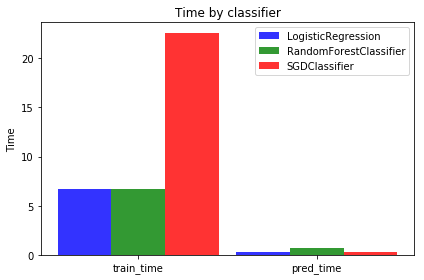

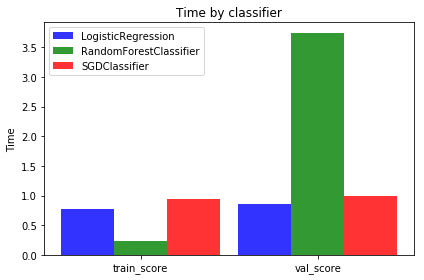

In [11]:
finding_cuisine.evaluate(results)
# train_time : time it takes to train a model
# pred_time : time takes to predict both validation and train datasets
# train_score : logloss score on train data
# val_score : logloss score on validation data

From the above graphs, we can state that SGDClassifier takes longest to train a model. Time taken by LogisticRegression and RandomForestClassifier are almost same

Prediction time for all three algorithms is approximately same but RandomForestClassifier takes slightly more time

We know that for logloss function good lies between 0 to 1. RandomForestClassifier preforms good on train data but not on validation set, it tends to overfit on training data. Train and val score for rest of the two algorithms are almost same and lies in range of 0 to 1.

From the above discussion we can say that LogisticRegression is a good algorithm for this model as it takes less time to train and predict and has better efficiency than other two. So we will be using the **LogisticRegression** for our model

## Train final model

In [37]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.metrics import log_loss
clf = LogisticRegression()

C = [1.0, 10.0, 50.0, 100.0]
solver = [  'liblinear']

parameters = {'C': C, 'solver': solver}

scorer = make_scorer(log_loss, greater_is_better=False, needs_proba=True)

grid_obj = GridSearchCV(clf, scoring=scorer, param_grid=parameters)
print('Grid search start')
grid_fit = grid_obj.fit(X_train, Y_train)
print('Grid search ends')
# Get the estimator
best_clf = grid_fit.best_estimator_


Grid search start
Grid search ends


In [45]:
# Note : Grid search with multiple solvers was not working on my system 
#        so I checked different solvers on validation set manually

predictions = best_clf.predict_proba(X_val)
op = log_loss(y_pred=predictions, y_true=Y_val)
op

0.7423594449424431

In [40]:
best_clf

LogisticRegression(C=10.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

After iterating through different parameters above given parameters are the best for model and logloss score is 0.74, 
Now we will run our test set through this model

In [44]:
test_predicions = best_clf.predict_proba(X_test)
eff = log_loss(y_pred=test_predicions, y_true=Y_test)
eff

0.73190397695505327

The logloss score for our test set is 0.73 this is almost same as validation set.

This score is much better from our benchmark model score that was 13.06, which means our model is better.

# Cuisine Diffusion

## Create a TfIdf matrix from count matrix of ingredients

In [2]:
cuisine_ingredient_dict, cuisines, ingredients = cuisine_diffusion.create_cuisine_ingredient_dict(data)

In [3]:
count_matrix = cuisine_diffusion.count_matrix(cuisine_ingredient_dict, cuisines, ingredients)

In [4]:
tfidf_matrix = cuisine_diffusion.tf_idf_from_count_matrix(count_matrix)

## Apply PCA

In [5]:
get_ipython().magic(u'matplotlib inline')
from sklearn.decomposition import PCA
from IPython.display import display
pca = PCA(n_components=2)
reduced_data = pca.fit_transform(tfidf_matrix)
display(pca.explained_variance_)

array([ 0.11622956,  0.06385513,  0.04190229,  0.03565582,  0.02832538,
        0.02311667])

First PC has the highest variance. for second PC variance is only 0.06 which is very less than the first one. After that is very little change. For this model we will only use first two PC only. 

In [6]:
pca_all = pd.DataFrame(reduced_data)
pca_all.columns = ['PC1', 'PC2','PC3', 'PC4','PC5', 'PC6']
pca_1_2 = pca_all[['PC1', 'PC2']]

## K-means

In [7]:
from sklearn.cluster import KMeans

kmeans = KMeans(init='k-means++', n_clusters=3, n_init=10)
kmeans.fit(pca_1_2)
labels = kmeans.predict(pca_1_2)

## Visualization

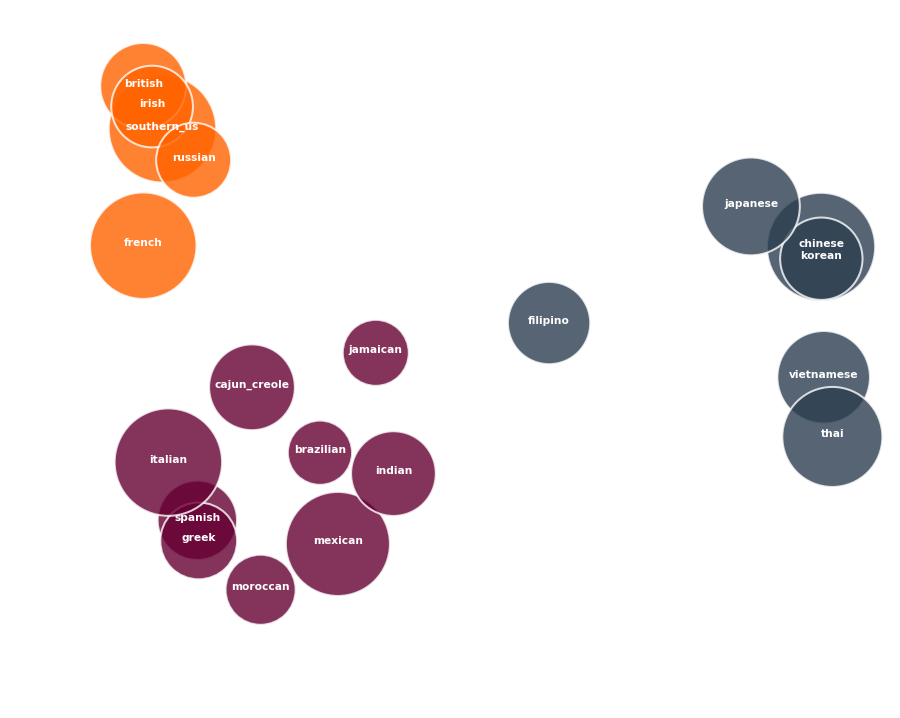

In [9]:
cuisine_diffusion.diffusion(cuisine_ingredient_dict, cuisines, labels, reduced_data)

In the above visualization we have 3 clusters of cuisines. As we have already defined in our model that similar cuisines will be near and dissimilar ones far. All the east Asian cuisines (korean, chinese etc) are in one group and europian are grouped together far from Asian. Another groups are british-irish cuisines and thai-vietnmese cuisines.

This is clear from the above graph that the cuisines are diffused properly with one another in our model.